In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt

N = 64

def WaveEq():
    u = tf.input([-1, -1], tf.float32)
    v = tf.input([-1, -1], tf.float32)

    i,j = u.indices

    laplacian = u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1] - u * 4.0 - 0.08 * tf.sin(2.0*np.pi*u)

    dt = 0.15
    v_new = v + dt*laplacian
    u_new = u + dt*v_new

    return [u_new, v_new]

tf.initialize(tf.cpu, "H:/tinycc/win32/tcc.exe")
test = tf.program(WaveEq)
#test.list_operations(compact=True)
#test.kernel_c()


TensorFrost module loaded!
dim =  2


In [2]:
#intialize as a gaussian pulse in the middle
Anp = np.zeros((N, N))
Bnp = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        Anp[i, j] = np.exp(-((i-N/3)**2 + (j-N/3)**2)/10)

A = tf.memory(Anp)
B = tf.memory(Bnp)
A, B = test(A, B)

print("Used memory: " + str(tf.used_memory()))

Used memory: 16388


In [3]:
#do a few steps and measure performance by timing every 100 steps
import time
start = time.time()

print("Used memory: " + str(tf.used_memory()))

for i in range(10000):
    A, B = test(A, B)
    if i % 100 == 99:
        print("Iterations per second: " + str(100/(time.time()-start)))
        start = time.time()

print("Used memory: " + str(tf.used_memory()))

Used memory: 16388
Iterations per second: 1587.3805955462706
Iterations per second: 1612.8960807235587
Iterations per second: 1562.4444485835088
Iterations per second: 1538.5166165358373
Iterations per second: 1639.35415534823
Iterations per second: 1612.8588677736163
Iterations per second: 1538.443255218554
Iterations per second: 1515.1463921249888
Iterations per second: 1587.3145145114838
Iterations per second: 1612.90848542181
Iterations per second: 1562.4851921114
Iterations per second: 1492.5392679472488
Iterations per second: 1562.5201168266078
Iterations per second: 1639.3669703614241
Iterations per second: 1562.5550431031272
Iterations per second: 1515.1628122042323
Iterations per second: 1515.1463921249888
Iterations per second: 1612.8898784459852
Iterations per second: 1562.4444485835088
Iterations per second: 1515.1847061968513
Iterations per second: 1612.939498002238
Iterations per second: 1612.8836762161122
Iterations per second: 1587.2544456175804
Iterations per second: 1

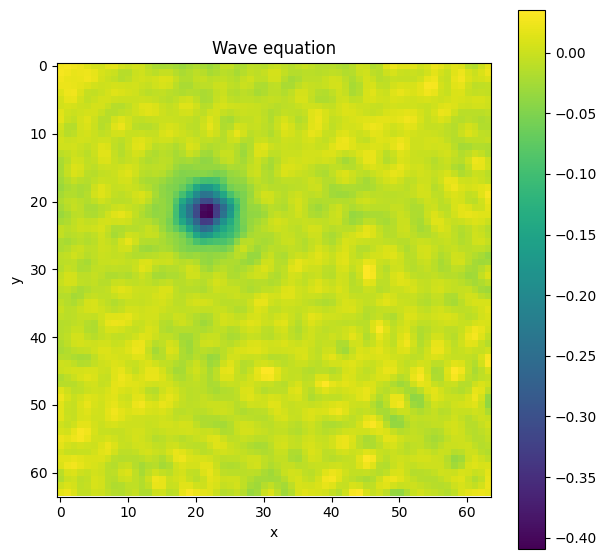

In [4]:
# Plot the results (with colorbar)
plt.figure(figsize=(7,7))
plt.imshow(A.numpy)
plt.colorbar()
plt.title("Wave equation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()



In [9]:
# Poisson equation solver test
# source term is a point source in the middle

def PoissonStep():
    u = tf.input([-1, -1], tf.float32)
    f = tf.input([-1, -1], tf.float32)

    i,j = u.indices

    u = (u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1] - f[i, j]) / 4.0
    u = (u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1] - f[i, j]) / 4.0
    u = (u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1] - f[i, j]) / 4.0
    u = (u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1] - f[i, j]) / 4.0

    return [u]

poisson = tf.program(PoissonStep)

dim =  2


Iterations per second: 58.651078226253695
Iterations per second: 58.61665223949973
Iterations per second: 58.548035781787156
Iterations per second: 58.51375510685241
Iterations per second: 58.20732490392116
Iterations per second: 58.8927339721295
Iterations per second: 58.68552004068792
Iterations per second: 59.031893630942854
Iterations per second: 58.858131172271044
Iterations per second: 58.96227728030693


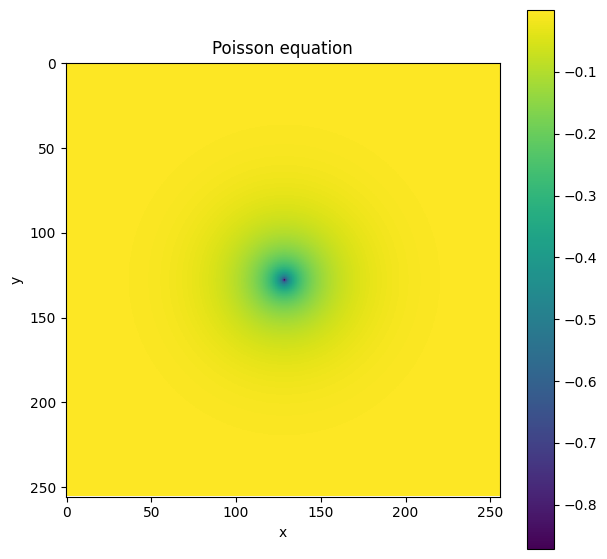

In [10]:
N = 256

#intialize as a gaussian pulse in the middle
Fnp = np.zeros((N, N))
Fnp[N//2, N//2] = 1.0

F = tf.memory(Fnp)
U = tf.memory(np.zeros((N, N)))

#do a few steps and measure performance by timing every 100 steps
start = time.time()

for i in range(1000):
    U, = poisson(U, F)
    if i % 100 == 99:
        print("Iterations per second: " + str(100/(time.time()-start)))
        start = time.time()

# Plot the results (with colorbar)
plt.figure(figsize=(7,7))
plt.imshow(U.numpy)
plt.colorbar()
plt.title("Poisson equation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [7]:
poisson.kernel_c()

#include <math.h> 
typedef unsigned int uint; 

float asfloat(uint x) 
{ 
  return *(float*)&x; 
} 

uint asuint(float x) 
{ 
  return *(uint*)&x; 
} 

int clamp(int x, int min, int max) 
{ 
  if(x < min) return min; 
  if(x > max) return max; 
  return x; 
} 

void kernel_0(uint* variables, uint* offsets, uint* memory, uint thread_id)
{
  int var1_0 = thread_id;
  int var1_2 = 1 * variables[0];
  int var1_3 = var1_0 / var1_2;
  int var1_5 = var1_0 / 1;
  int var1_6 = var1_5 % variables[1];
  int var1_8 = var1_6 - 1;
  int var1_10 = var1_6 + 1;
  int var1_12 = variables[2] - 1;
  int var1_14 = clamp(var1_3, 0, var1_12);
  int var1_15 = var1_14 * variables[3];
  int var1_17 = variables[4] - 1;
  int var1_19 = clamp(var1_8, 0, var1_17);
  int var1_20 = var1_15 + var1_19;
  float var1_21 = asfloat(memory[offsets[0] + var1_20]);
  int var1_23 = variables[5] - 1;
  int var1_25 = clamp(var1_3, 0, var1_23);
  int var1_26 = var1_25 * variables[6];
  int var1_28 = variables[7] - 1;
  int var1_3